# Part 2. Predict future stock prices using machine learning models.

##  Description:
In this part we will develop a model to predict the future stock prices. 
After reading a several articles and a study I decided to use the following approach:
1. Choose few Models I will be utilizing.  
    1. ARIMA (AutoRegressive Integrated Moving Average) with transformed data into stationary.
    2. LSTM - Long Short Term Memory Neural Network  
    3. Linear Regression
    2. RF - Random Forest
    3. SVM - Support Vector Machine
    2. XGBoost
    
2. Build simple model to predict the stock price based on just a few features (Price, few indicators, few fundamentals). And prepare it to accomodate more features later. So testing of a model can be easily done. 

## 2.0 Import Libraries, Data, Prepare to feed data into models

#### 2.0.1 Import Libraries, Set Global Parameters

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from Data_Retrieval_Transformation import AlphaVantageAPI as AV
from Data_Retrieval_Transformation import AV_Plots
from Data_Retrieval_Transformation import Indicators as Ind


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 


plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('Solarize_Light2')

DATA_DIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\Stock Analysis Data'
PREDICTION_DAYS = 50 # for our AR models
TEST_PREDICTION_DAYS = 20 # for us to preddict on test data

# API Settings
import yaml
def load_yaml_file(filename):
    with open(filename, "r") as file:
        data = yaml.safe_load(file)
    return data

KEY = load_yaml_file(r"C:\Users\Vasyl\Google Drive\Vantage API Secret key\AlphaVantageAPIPremiumKey.yaml")['ALPHA_VANTAGE_PREMIUM_KEY']
CALLS_PER_MINUTE = 75
SLEEP_TIME = 60/CALLS_PER_MINUTE + (60/CALLS_PER_MINUTE)*0.1 # 75 requests per minute with 10% buffer


config = {
    "alpha_vantage": {
        "key": KEY, # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "VZ",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
        "key_volume": "6. volume",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
        "val_split_size": 0.20,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

### 2.0.2 Load Data

In [456]:
def download_data(config):
    ts = TimeSeries(key=config['alpha_vantage']['key']) #you can use the demo API key for this project, but please make sure to eventually get your own API key at https://www.alphavantage.co/support/#api-key. 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    data_volume = [float(data[date][config["alpha_vantage"]["key_volume"]]) for date in data.keys()]
    data_volume.reverse()
    data_volume = np.array(data_volume)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data, data_date, data_close_price, data_volume, display_date_range

json_data_full, data_date, data_close_price, data_volume, display_date_range = download_data(config)

Number data points 5935 from 1999-11-01 to 2023-06-02


In [455]:
data = {'Close': data_close_price, 'Volume': data_volume}
df = pd.DataFrame(data = data, index=data_date)
df.index.name = 'Date'
df.index = pd.to_datetime(df.index)
df['Close - 1'] = df['Close'].shift(1)
df.head(2)

,Close,Volume,Close - 1
Date,,,
1999-11-01,19.778786,4260300.0,NaN
1999-11-02,19.336802,2668800.0,19.778786


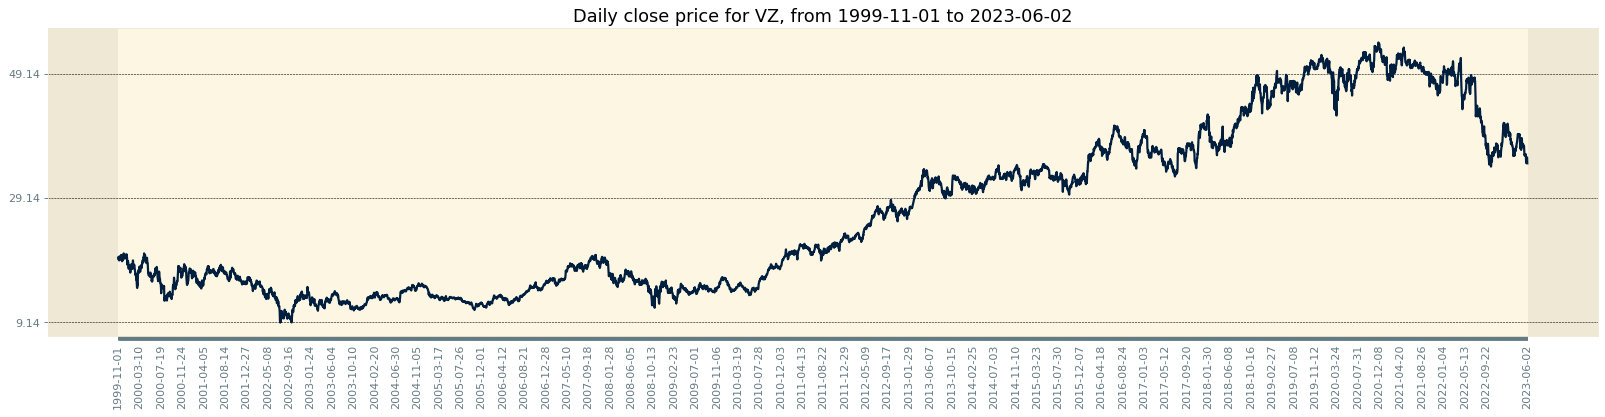

In [457]:
# plot
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (df.shape[0]-i) > config["plots"]["xticks_interval"]) or i==df.shape[0]-1) else None for i in range(df.shape[0])] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.yticks(np.arange(min(data_close_price), max(data_close_price), 20))
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)

plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')

plt.show()

## 2.1 Prepare indexes to Split Data into Train, Validation, Test Sets

In [476]:
test_df = df.iloc[-TEST_PREDICTION_DAYS:]
df = df.iloc[:-TEST_PREDICTION_DAYS]

train_df = df.iloc[ : int(df.shape[0] * config["data"]["train_split_size"])]
val_df = df.iloc[- int(df.shape[0] * config["data"]["val_split_size"]) : ]

print("Train DF end:  ", train_df.shape)
print("Val DF end:    ", val_df.shape)
print("Test DF end:   ", test_df.shape)
print("Total values:  ", train_df.shape[0], "+", val_df.shape[0], "+", test_df.shape[0], "=", train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

Train DF end:   (4732, 3)
Val DF end:     (1183, 3)
Test DF end:    (20, 3)
Total values:   4732 + 1183 + 20 = 5935


## 2.2 Building a persistence (base) model to establish a baseline.  
We will build a model model that basically take a previous day value and uses it as a prediction for the next day. This will be our baseline model. We will use it to compare with other models.  

Mertics we will use to compare models are:
* MAPE - Mean Absolute Percentage Error
* MASE - Mean Absolute Scaled Error

Test RMSE: $ 0.486
Test MAE: $ 0.334
Test MAPE: 0.009
Test MASE: 1.000


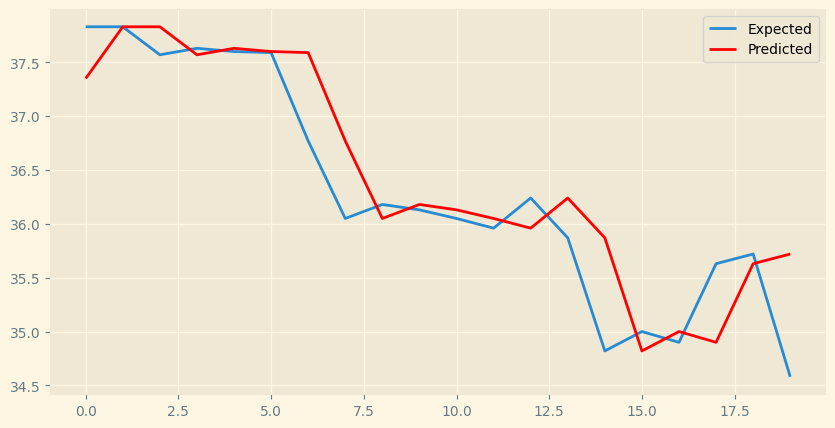

In [475]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

y_true = df['Close'].iloc[-TEST_PREDICTION_DAYS:]
y_pred = df['Close - 1'].iloc[-TEST_PREDICTION_DAYS:]
naive_forecast = df['Close - 1'].iloc[-TEST_PREDICTION_DAYS:]

# create MASE function
def mean_absolute_scaled_error(y_true, y_pred, naive_forecast):
    ''' MASE = MAE\MAE_naive '''
    mae = mean_absolute_percentage_error(y_true, y_pred)
    mae_naive = mean_absolute_percentage_error(y_true, naive_forecast)
    return mae/mae_naive

print(f'Test RMSE: $ {round(np.sqrt(mean_squared_error(y_true, y_pred)),3)}')
print(f'Test MAE: $ {round(mean_absolute_error(y_true, y_pred),3)}')
print('Test MAPE: %.3f' % mean_absolute_percentage_error(y_true, y_pred))
print('Test MASE: %.3f' % mean_absolute_scaled_error(y_true, y_pred, naive_forecast))

# plot predictions vs expected
plt.plot(y_true.values)
plt.plot(y_pred.values, color='red')
plt.legend(['Expected', 'Predicted'])
plt.show()

MASE is 1 - meaning that our model is as good as the baseline model.

## 2.3 Exploratory analysis. - Plots

####  2.2.1 Ploting some data to see how it looks.

<Axes: title={'center': ' VZ Adjusted Daily Close Price Growth'}, xlabel='Date'>

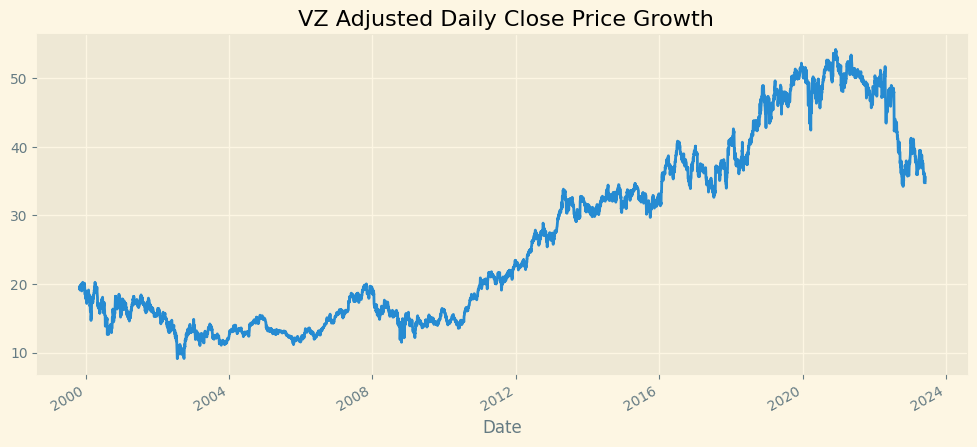

In [322]:
# Glance on a Price chart
df['Close'][:].plot(figsize=(12,5), title=' VZ Adjusted Daily Close Price Growth')

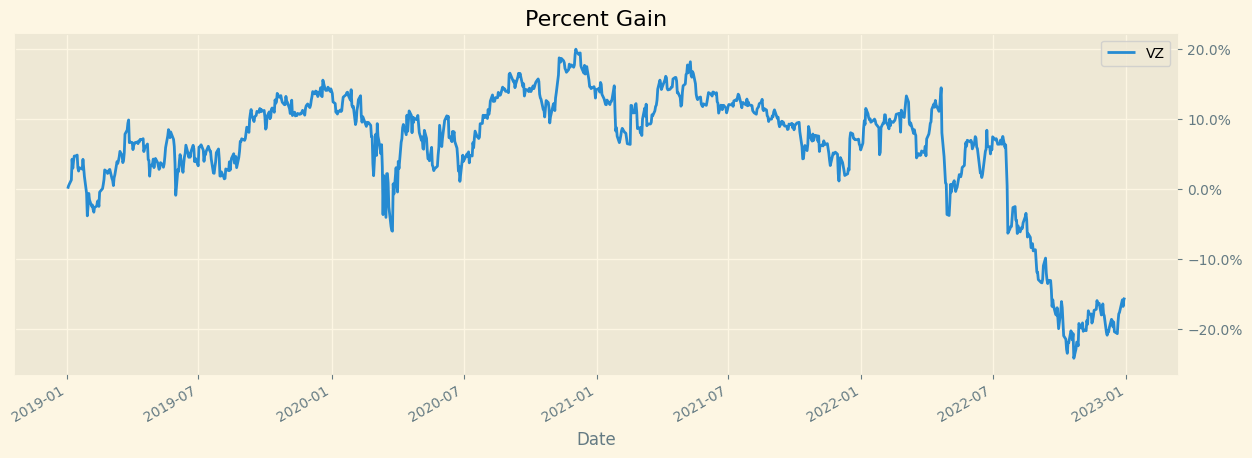

In [323]:
# Glance on the % change over time
AV_Plots.plot_prct_gain(['VZ'], '2019-01-01', '2022-12-31')

#### 2.2.2 Probability distribution

<Axes: ylabel='Density'>

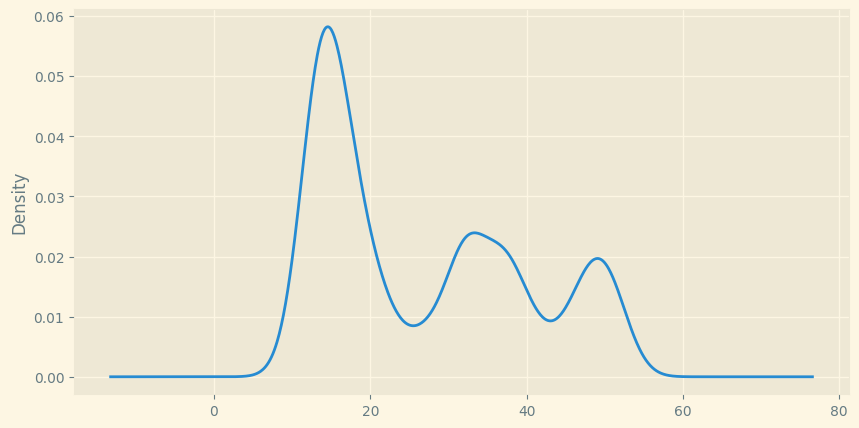

In [324]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')

## 2.4 Exploratory analysis. - Tests for stationarity. AC, PAC, ADF (Augmented Dickey-Fuller).

### 2.4.1 Determining Autocorrelation and Partial Autocorrelation to better understand data.

Glance on ACF - Autocorrelation Function and PACF - Partial Autocorrelation Function

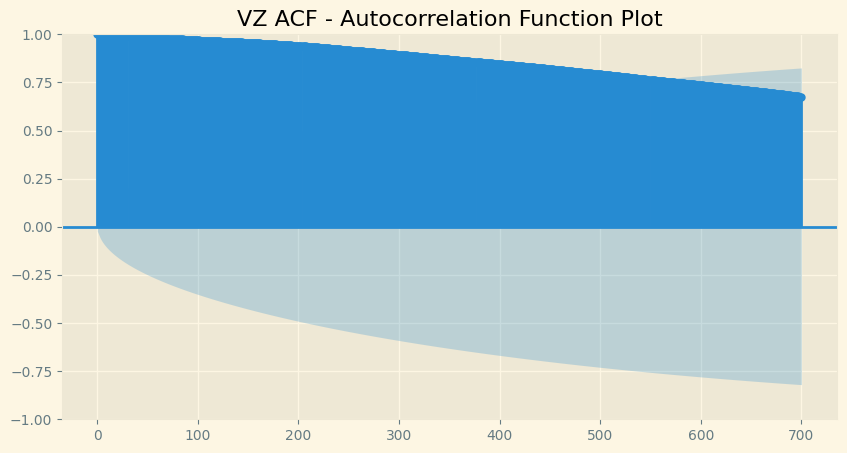

In [325]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
figure_AXF = plot_acf(df['Close'], lags=700, title='VZ ACF - Autocorrelation Function Plot', alpha=0.05)

From above we can see that our values can be predicted from values lagging about 550 days if we count the all relationships including indirect ones. This Will give us an indication whether we can use MA (Moving Average) model and if so what is the lag we should use.

Now we will take a look how to prevent multicolinearity using Partial Autocorrelation Function (PACF) plot. This chart will show us how many lags actually impacting our time series after removing the noise. Or How many lags actually have a direct impact on our time series. PACF will give us an idea of how to build our AR model.

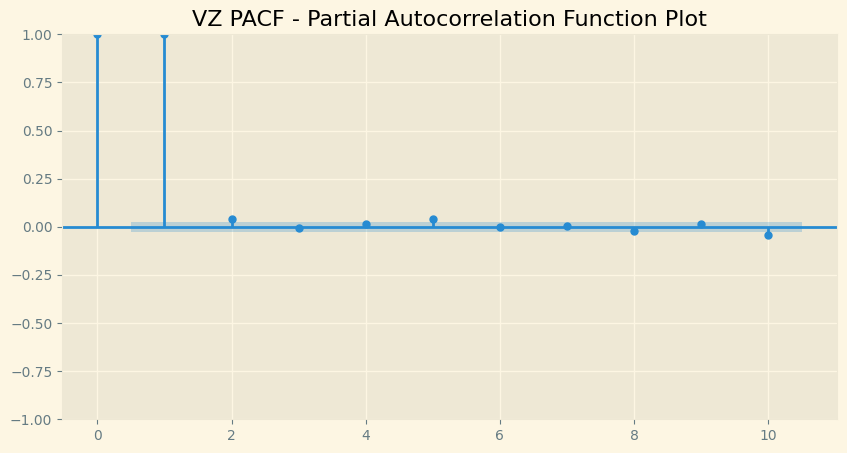

In [326]:
figure_AXF = plot_pacf(df['Close'], lags=10, method='ols' , title='VZ PACF - Partial Autocorrelation Function Plot')

We can see few things here : 
* There are many Autocorrelation values that are very close to 1. This means that the time series is not random. And strongly suggest that we see non-stationary time series.
* We have very high degree of correlation between the lag 1 and data in PACF plot. This means that we can use AR model with lag 1. AR(1) model.
* We can see almost linear decay at ACF

let's take a look at correlation using pandas native functions as well. 

In [327]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

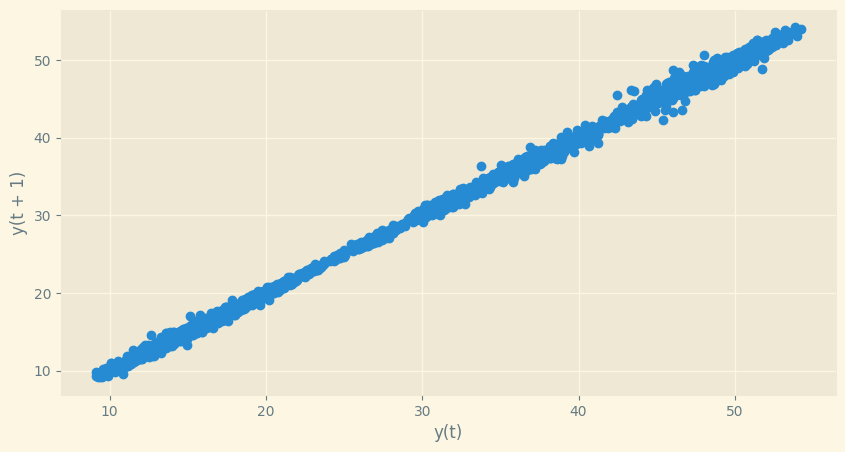

In [328]:
lag_plot(df['Close'], lag=1)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

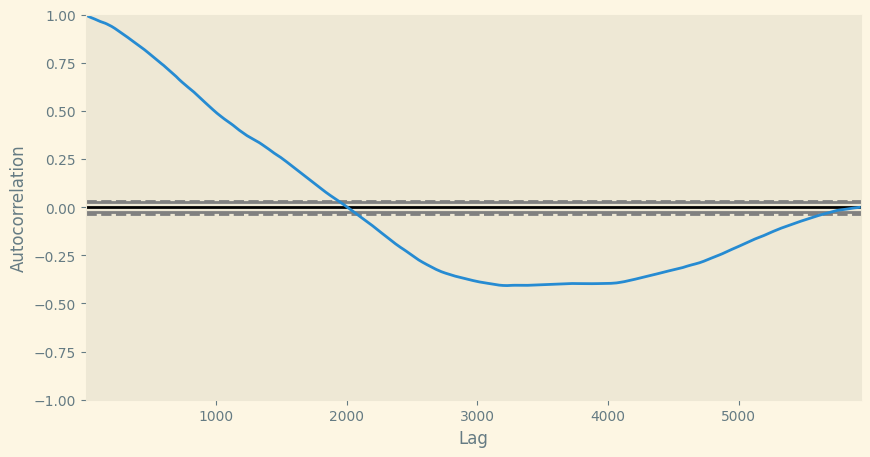

In [329]:
autocorrelation_plot(df['Close'])

### 2.4.2 ADF Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance)  
This test’s null and alternate hypotheses are:  
* Null Hypothesis: The series has a unit root (value of a =1)
* Alternate Hypothesis: The series has no unit root.

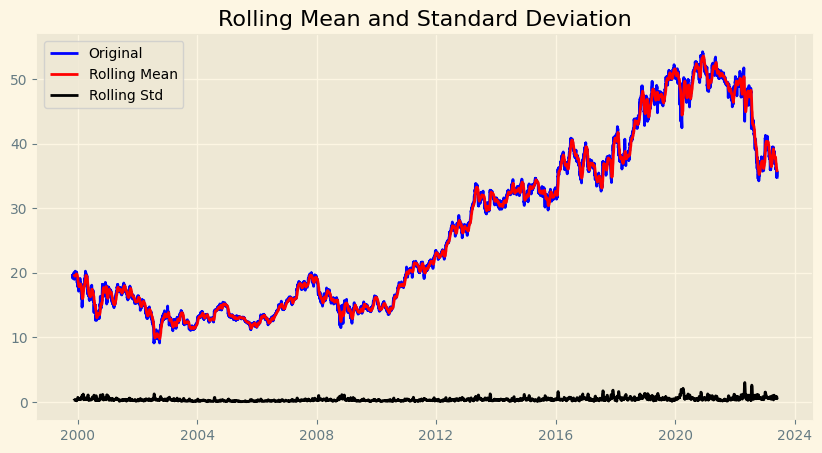

Results of dickey fuller test
Test Statistics                  -0.810204
p-value                           0.816106
No. of lags used                 27.000000
Number of observations used    5907.000000
critical value (1%)              -3.431458
critical value (5%)              -2.862029
critical value (10%)             -2.567031
dtype: float64


In [330]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

Increasing mean and different STD can be seen on the plot. This is an indication that our time series is not stationary.  
We also see p-value grater than 0.05. This means that we can not reject the null hypothesis. And our time series is not stationary.

### 2.4.3 Isolating time series from trend and seasonality.
Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

<Figure size 1000x500 with 0 Axes>

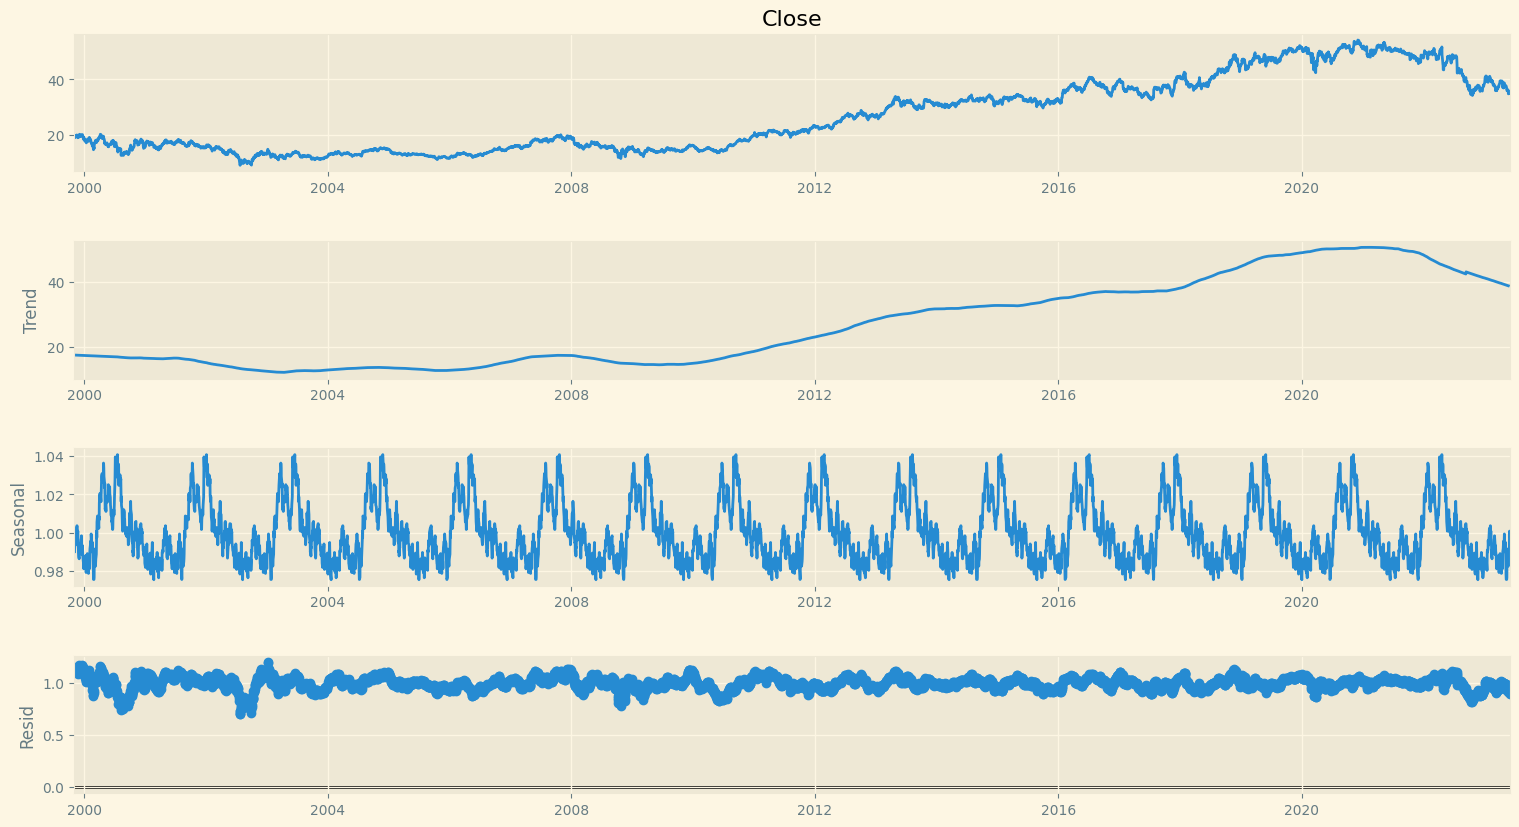

In [331]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', extrapolate_trend='freq', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Here are a few reasons why applying a logarithmic transformation is beneficial:

* <strong>Stabilizing Variance</strong>: By taking the logarithm of a time series, you can reduce the variability in the data. This is especially valuable when the variance of the series increases with the magnitude of the values. By compressing the scale, the logarithmic transformation can help make the variance more consistent across the range of values.

* <strong>Handling Exponential Growth</strong>: If your time series exhibits exponential growth, applying a logarithmic transformation can convert it into a more linear pattern. This can be useful when analyzing or modeling data that grows at a compounded rate over time. The transformation makes it easier to identify linear trends or relationships that might be masked in the original scale.

* <strong>Reducing Skewness</strong>: Skewness refers to the asymmetry of the data distribution. In some cases, a time series might have a skewed distribution, with a long tail on one side. By taking the logarithm, you can often reduce the skewness and make the distribution more symmetric. This can be particularly advantageous when using statistical techniques that assume normality or symmetric distributions.

* <strong>Making Trends More Linear</strong>: In some cases, trends in a time series might not be linear but exhibit exponential or power-law growth. Taking the logarithm can help transform these trends into more linear patterns. By doing so, you can often simplify the analysis, apply linear regression techniques, or capture the trend more effectively using simpler models.

## 2.5 Building an Autoregression Model - ARIMA - AutoRegressive Integrated Moving Average.
We will use ARIMA model.
Stationary time series must have next properties, which are better after log transformation:
* Constant mean over time
* Constant variance over time
* Autocovariance that does not depend on time, meaning that the time series is not a function of time or it does not have a trend.

### 2.6.0 SCALING DATA to make it stationary.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


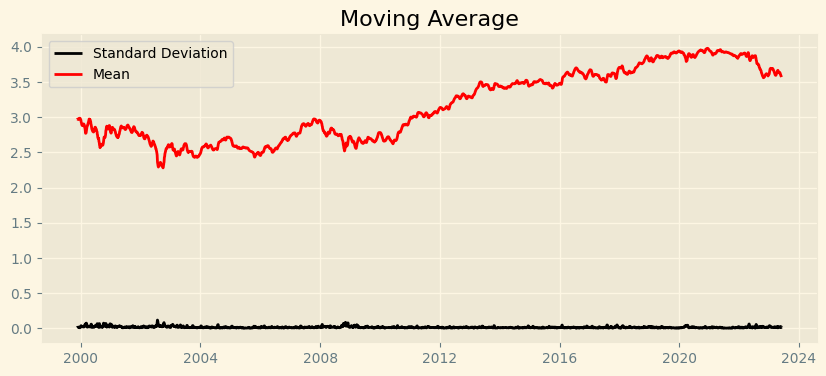

In [332]:
# Smooting trend and stabilizing variance
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Log Series')

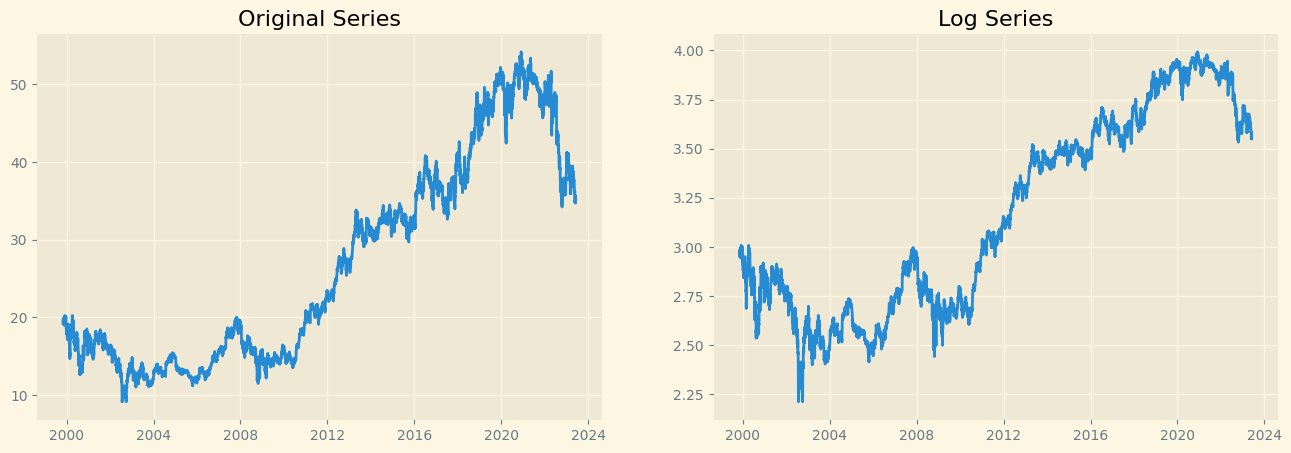

In [333]:
# Quick Glance on our Log  output
fig, axes = plt.subplots(1, 2, figsize=(16,5))
axes[0].plot(df['Close']); axes[0].set_title('Original Series')
axes[1].plot(np.log(df['Close'])); axes[1].set_title('Log Series')

### 2.6.1 Split data into train and test sets for ARIMA model only. 
Accounting for how many data points impact our model. From Analysis of ACF and PACF we know that we can use 550 data points. So we will use 550 data points for training and X data points for testing. X set in a first cell in PREDICTION_DAYS variable.

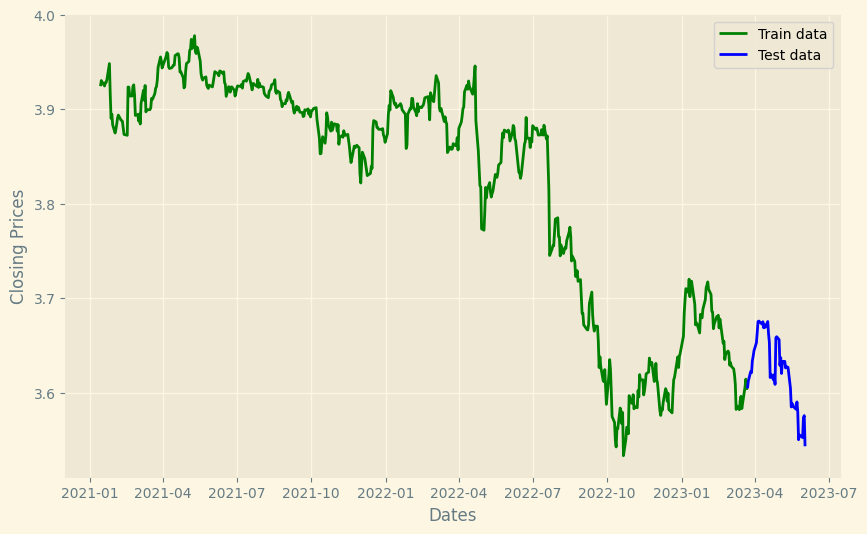

In [334]:
train_data = df_log.iloc[-550-PREDICTION_DAYS:-PREDICTION_DAYS]
test_data = df_log.iloc[-PREDICTION_DAYS:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### 2.6.2 Building ARIMA model and determining the best parameters for the model.

In [335]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3292.921, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3293.073, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3292.956, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3293.618, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3291.246, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.662 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1647.809
Date:                Sun, 04 Jun 2023   AIC                          -3293.618
Time:                        22:41:11   BIC                          -3289.309
Sample:                             0   HQIC                         -3291.934
                                - 550                                  

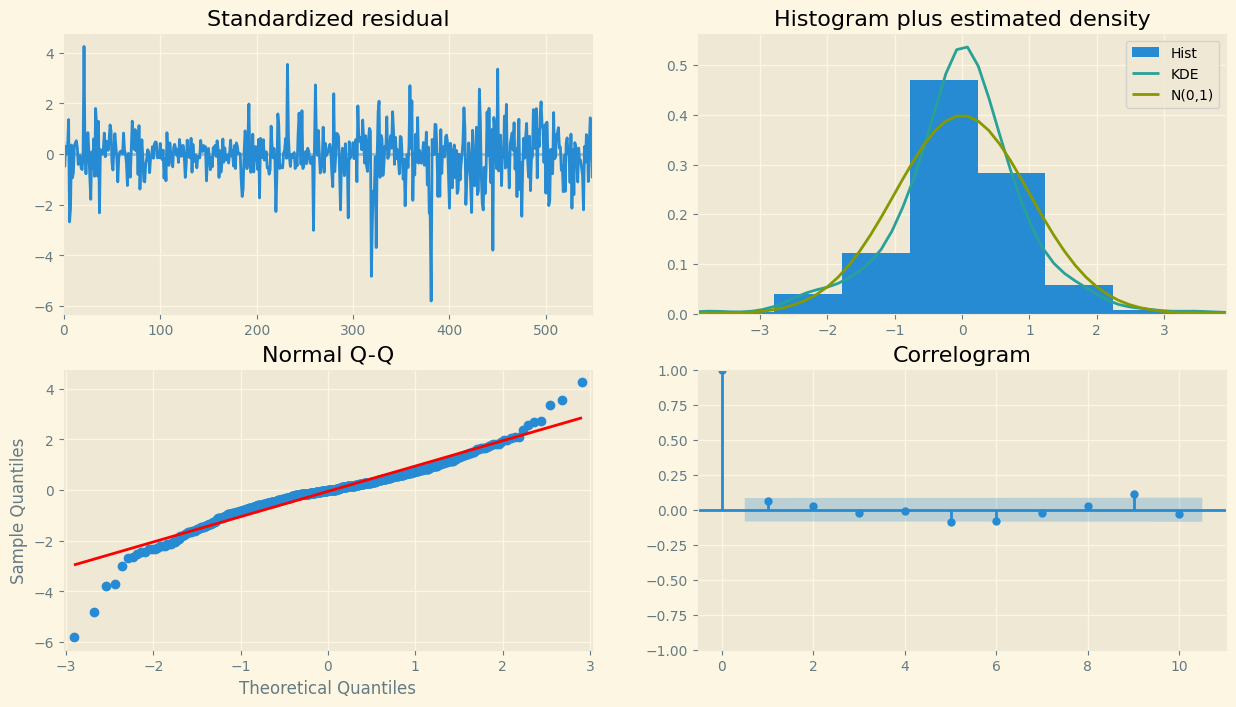

In [336]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                            test='adf',       # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1,              # frequency of series
                            d=None,           # let model determine 'd'
                            seasonal=False,   # No Seasonality
                            start_P=0, 
                            D=0, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

__Top left:__ The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

__Top Right:__ The density plot on the top right suggests a normal distribution with a mean of zero.

__Bottom left:__ The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

__Bottom Right:__ The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

### 2.6.3 - Predicting the future values using ARIMA model.

In [337]:
# Build Model
model = ARIMA(train_data, order=(0,1,0), trend='t')  
fittedARIMA = model.fit()  
print(fittedARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  550
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1648.460
Date:                Sun, 04 Jun 2023   AIC                          -3292.921
Time:                        22:41:12   BIC                          -3284.304
Sample:                             0   HQIC                         -3289.553
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0006      0.001     -1.122      0.262      -0.002       0.000
sigma2         0.0001    5.1e-06     28.306      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.16   Jarque-

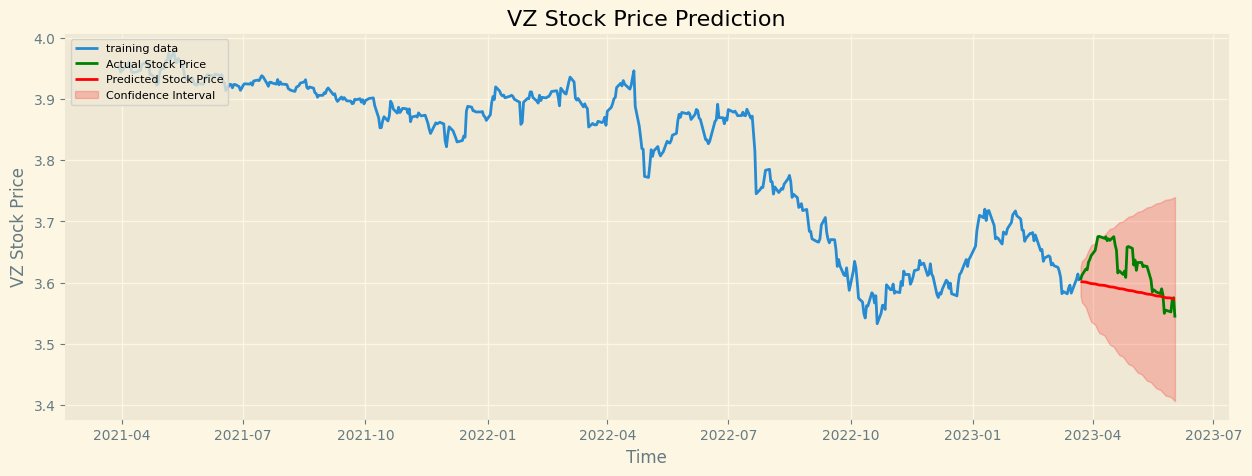

In [338]:
# Forecast
fc = fittedARIMA.forecast(PREDICTION_DAYS)

# Results
fc_results = fittedARIMA.get_forecast(PREDICTION_DAYS)
fc_params_summary = fc_results.summary_frame()

# Make as pandas series
fc.index = test_data.index
fc_series = fc
lower_series = pd.Series(fc_params_summary['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(fc_params_summary['mean_ci_upper'].values, index=test_data.index)

# Plot last PREDICTION_DAYS*10 days of training set and forecast results
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train_data.iloc[-PREDICTION_DAYS*10:], label='training data')
plt.plot(test_data, color = 'green', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')

# fill between lower and upper confidence band 
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.20, label='Confidence Interval', interpolate=True)
plt.title('VZ Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VZ Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [339]:
print(fc_params_summary.shape)
fc_params_summary.head(2)

(50, 4)


Close,mean,mean_se,mean_ci_lower,mean_ci_upper
550,3.602278,0.012019,3.578722,3.625834
551,3.601688,0.016997,3.568374,3.635001


### 2.6.4 - Rescaling back to original values and plotting zoomed results.

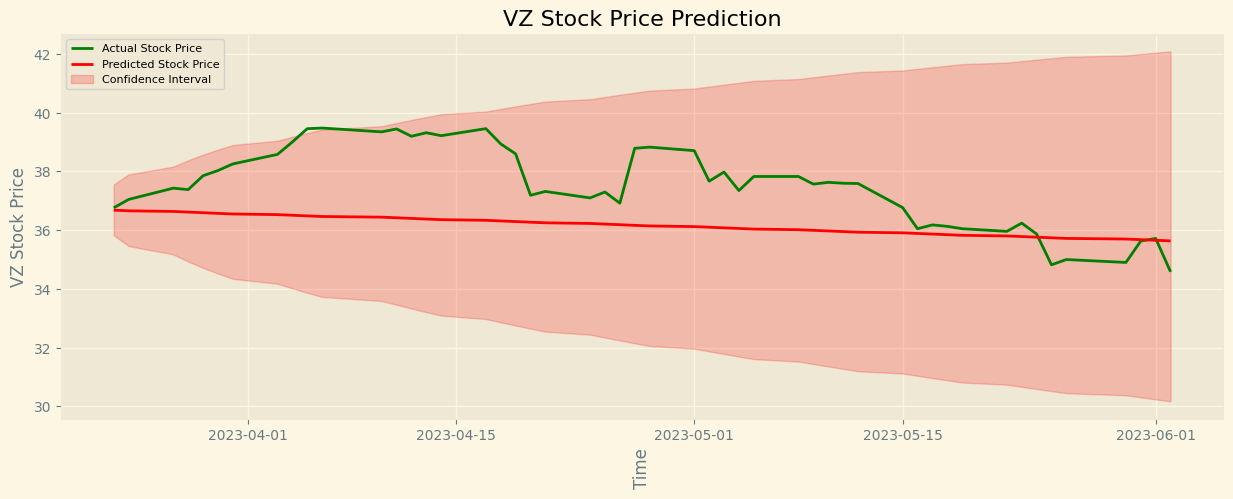

In [340]:
# transforming to original scale
fc_series_exp = np.exp(fc_series)
lower_series_exp = np.exp(lower_series)
upper_series_exp = np.exp(upper_series)
test_data_exp = np.exp(test_data)
# Plot only the predictions and the confidence interval
plt.figure(figsize=(15,5), dpi=100)
plt.plot(test_data_exp, color = 'green', label='Actual Stock Price')
plt.plot(fc_series_exp, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series_exp.index, lower_series_exp, upper_series_exp, color='r', alpha=.20, label='Confidence Interval', interpolate=True)
plt.title('VZ Stock Price Prediction')
plt.xlabel('Time' , rotation='vertical')
plt.ylabel('VZ Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [341]:
# calculate mape, mase
naive_forecast_PREDICTION_DAYS = df['Close - 1'].iloc[-PREDICTION_DAYS:]
rmse = math.sqrt(mean_squared_error(test_data_exp, fc_series_exp))
mae = mean_absolute_error(test_data_exp, fc_series_exp)
mape = mean_absolute_percentage_error(test_data_exp, fc_series_exp)
mase = mean_absolute_scaled_error(test_data_exp, fc_series_exp, naive_forecast_PREDICTION_DAYS)
print(f'ARIMA {PREDICTION_DAYS} days RMSE: $ {round(rmse,3)}')
print(f'ARIMA {PREDICTION_DAYS} days MAE: $ {round(mae,3)}')
print(f'ARIMA {PREDICTION_DAYS} days MAPE: {round(mape,3)}')
print(f'ARIMA {PREDICTION_DAYS} days MASE: {round(mase,3)}')

ARIMA 50 days RMSE: $ 1.762
ARIMA 50 days MAE: $ 1.465
ARIMA 50 days MAPE: 0.038
ARIMA 50 days MASE: 4.025


* Our MAPE for 50 days is 0.038. This is a nice result. This means we are 96.2% accurate in our prediction.
* Our MASE for 50 days is 4.025 - it is over 1 which means that our model is not as good as the baseline model. This metric is here to compare our results with other models.   

## 2.7 Creating LSTM - Long Short Term Memory Neural Network model.

#### 4.5.2 Preparing data for LSTM model. Scaling data.

Standardize the data.

In [478]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
normalized_data_close_price = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
# reshape back to 1D array
normalized_data_close_price = normalized_data_close_price.reshape(-1)

#### 4.5.3 Feature Creation. Splitting the data into train, test and validation sets.

In [404]:
def prepare_data_x(x, window_size):
    # perform windowing
    print("x shape", x.shape)
    n_row = x.shape[0] - window_size + 1
    print("Number of rows", n_row)
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    
    print ("Output shape", output.shape)
    print('Srtides', x.strides)
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    print("y shape", output.shape)
    return output

In [479]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

x shape (5915,)
Number of rows 5896
Output shape (5896, 20)
Srtides (8,)
y shape (5895,)


In [480]:
data_x.shape, data_y.shape, data_x_unseen.shape

((5895, 20), (5895,), (20,))

In [481]:
print(data_x[0])
print(data_x[1])

[-0.52233722 -0.55580011 -0.54418105 -0.56439821 -0.57183441 -0.52233722
 -0.55858868 -0.54116009 -0.54418105 -0.55858868 -0.54696962 -0.52233722
 -0.50490863 -0.53256199 -0.51373911 -0.542322   -0.5818268  -0.57601727
 -0.55858868 -0.56439821]
[-0.55580011 -0.54418105 -0.56439821 -0.57183441 -0.52233722 -0.55858868
 -0.54116009 -0.54418105 -0.55858868 -0.54696962 -0.52233722 -0.50490863
 -0.53256199 -0.51373911 -0.542322   -0.5818268  -0.57601727 -0.55858868
 -0.56439821 -0.53767437]


In [482]:
data_x_train = data_x[ : int(df.shape[0] * config["data"]["train_split_size"])]
data_y_train = data_y[: int(df.shape[0] * config["data"]["train_split_size"])]

data_x_val = data_x[- int(df.shape[0] * config["data"]["val_split_size"]) : ]
data_y_val = data_y[- int(df.shape[0] * config["data"]["val_split_size"]) : ]

print("Train size", len(data_x_train))
print("Val size", len(data_x_val))

print('Sum of train, val', len(data_x_train) + len(data_x_val))

Train size 4732
Val size 1183
Sum of train, val 5915


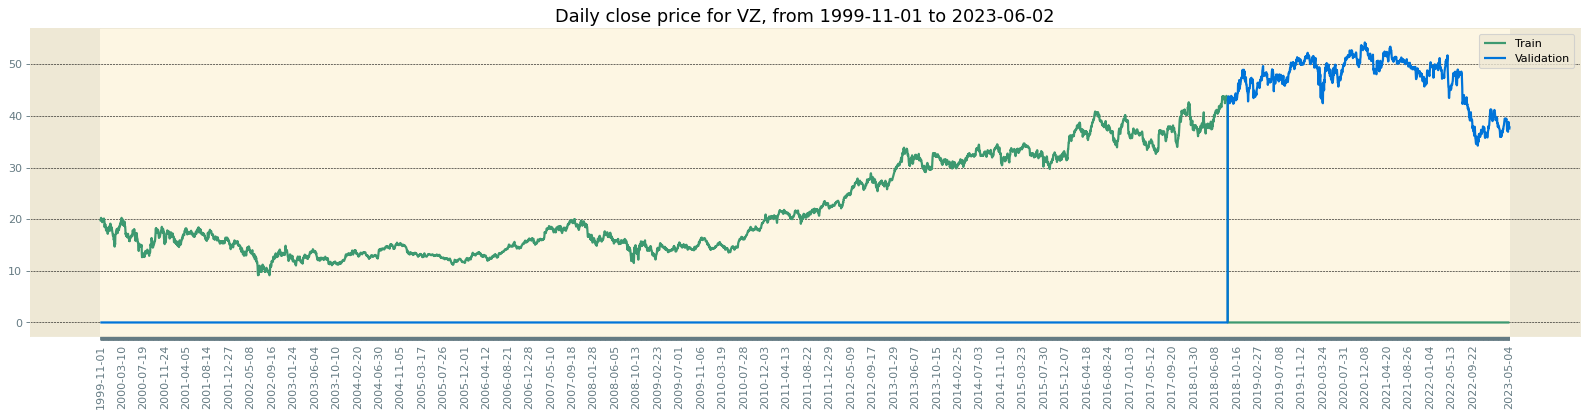

In [485]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(len(data_x_train) + len(data_x_val))
to_plot_data_y_val = np.zeros(len(data_x_train) + len(data_x_val))


to_plot_data_y_train[:len(data_y_train)] = scaler.inverse_transform(data_y_train.reshape(-1, 1)).reshape(-1)
to_plot_data_y_val[-len(data_y_val):] = scaler.inverse_transform(data_y_val.reshape(-1, 1)).reshape(-1)

# plot 
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_train, color=config["plots"]["color_train"])
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_val, color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (df['Close'].shape[0]-i) > config["plots"]["xticks_interval"]) or i==df['Close'].shape[0]-1) else None for i in range(df['Close'].shape[0])] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')

plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')
plt.legend(['Train', 'Validation', 'Test'])

plt.show()


#### 4.5.4 Creating DataLoader object for the data.

In [486]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4732, 20, 1) (4732,)
Validation data shape (1183, 20, 1) (1183,)


#### 4.5.5 Creating LSTM model.

In [487]:
# define model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

#### 4.5.6 Training the model.

In [488]:
# train model
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.028146, test:0.023342 | lr:0.010000
Epoch[2/100] | loss train:0.005919, test:0.013666 | lr:0.010000
Epoch[3/100] | loss train:0.004983, test:0.022160 | lr:0.010000
Epoch[4/100] | loss train:0.004872, test:0.014854 | lr:0.010000
Epoch[5/100] | loss train:0.004428, test:0.006315 | lr:0.010000
Epoch[6/100] | loss train:0.004361, test:0.011491 | lr:0.010000
Epoch[7/100] | loss train:0.003791, test:0.005805 | lr:0.010000
Epoch[8/100] | loss train:0.003997, test:0.004531 | lr:0.010000
Epoch[9/100] | loss train:0.003997, test:0.004055 | lr:0.010000
Epoch[10/100] | loss train:0.003810, test:0.006158 | lr:0.010000
Epoch[11/100] | loss train:0.004003, test:0.019759 | lr:0.010000
Epoch[12/100] | loss train:0.003786, test:0.017816 | lr:0.010000
Epoch[13/100] | loss train:0.003954, test:0.005662 | lr:0.010000
Epoch[14/100] | loss train:0.003823, test:0.014113 | lr:0.010000
Epoch[15/100] | loss train:0.003964, test:0.007513 | lr:0.010000
Epoch[16/100] | loss train:0.00370

#### 4.5.7 Predicting the future values using LSTM model.

In [489]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does
predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

#### 4.5.8 Rescaling back to original values and plotting results.

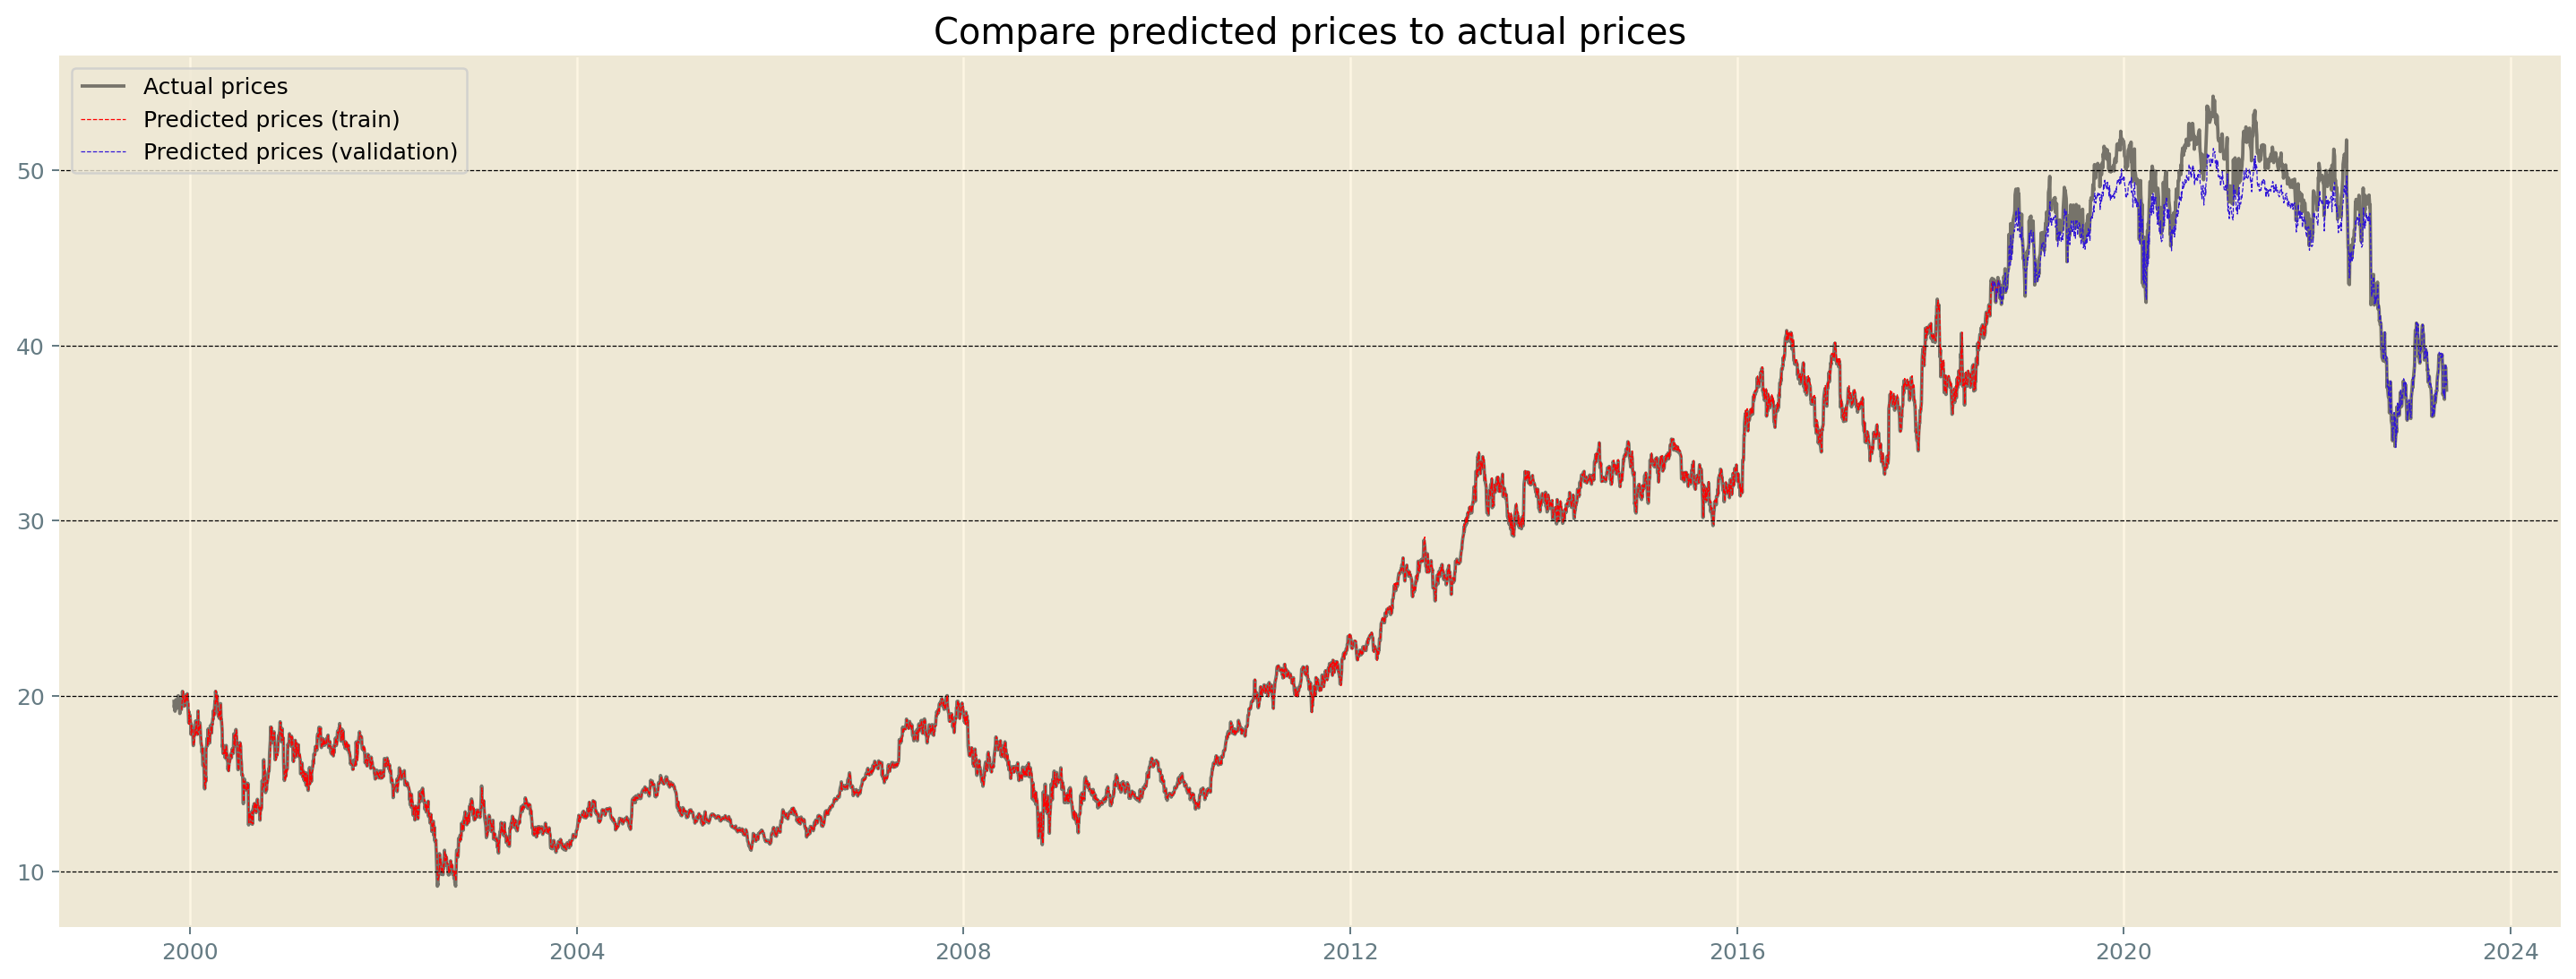

In [512]:
# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(df['Close'].shape[0])
to_plot_data_y_val_pred = np.zeros(df['Close'].shape[0])

to_plot_data_y_train_pred[config["data"]["window_size"] : int(df.shape[0] * config["data"]["train_split_size"])+config["data"]["window_size"]] = \
                                                                            scaler.inverse_transform(predicted_train.reshape(-1, 1)).reshape(-1)
to_plot_data_y_val_pred[- int(df.shape[0] * config["data"]["val_split_size"]) : ] = \
                                                                            scaler.inverse_transform(predicted_val.reshape(-1, 1)).reshape(-1)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(20, 7), dpi=180)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(df.index, df['Close'], label="Actual prices", color='black',
         linewidth=1.5, alpha=0.5, linestyle='-')
plt.plot(df.index, to_plot_data_y_train_pred, label="Predicted prices (train)", color='red', 
         linewidth=0.5, alpha=1, linestyle='--')
plt.plot(df.index, to_plot_data_y_val_pred, label="Predicted prices (validation)", color='#3218D6', 
         linewidth=0.5, alpha=1, linestyle='--')
plt.title("Compare predicted prices to actual prices")

plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')
plt.legend()
plt.show()

#### 4.5.9 Predicting the future values using LSTM model.

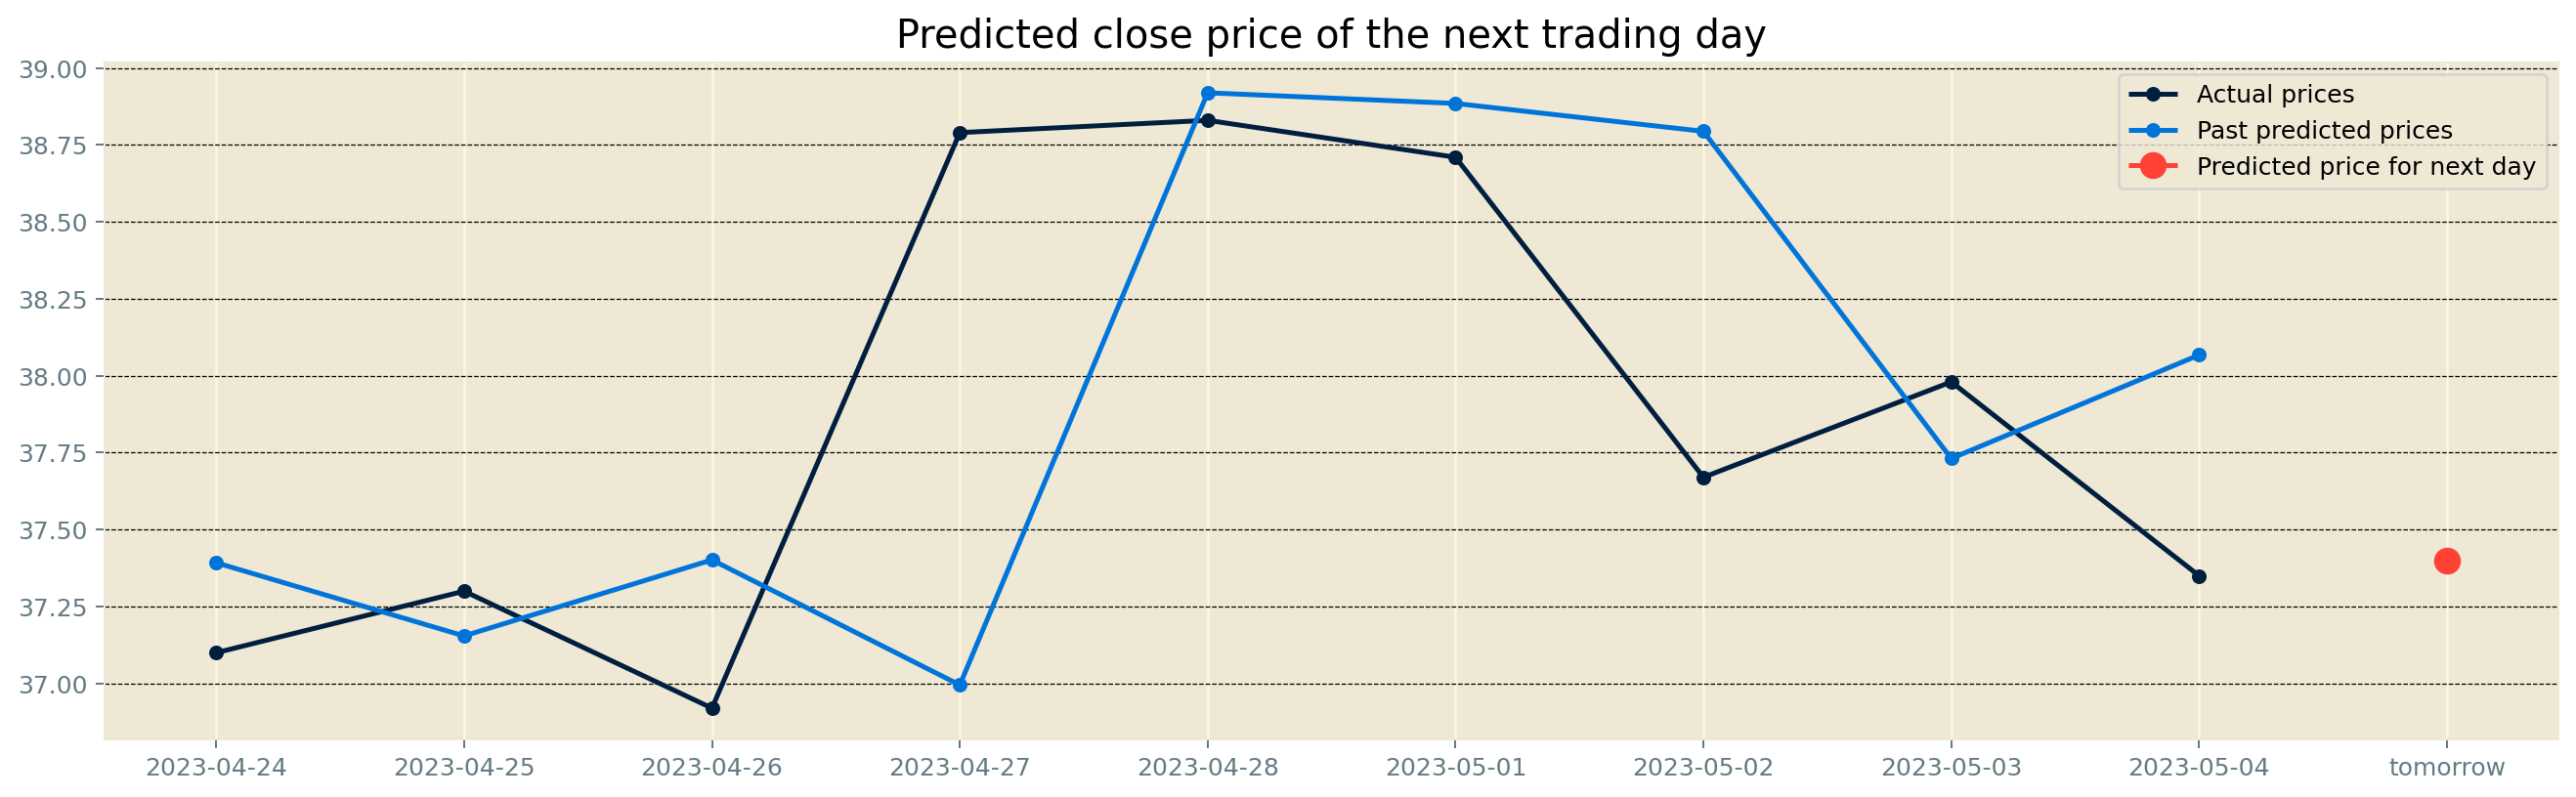

Predicted close price of the next trading day: 37.4


In [540]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val.reshape(-1,1)).reshape(-1)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val.reshape(-1,1)).reshape(-1)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot
dates = [str(date.date()) for date in df.index]
plot_date_test = dates[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(18, 5), dpi=180)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))

#### 4.5.10.  Calculating MAPE and MASE for LSTM model.

In [363]:
# Calculate MAPE and MASE for the validation set

# MAPE
mape = np.mean(np.abs((to_plot_data_y_val_pred - to_plot_data_y_val) / to_plot_data_y_val)) * 100
print("MAPE:", round(mape, 2), "%")

# MASE
# calculate naive forecast
naive_forecast = np.roll(to_plot_data_y_val, 1)
naive_forecast[0] = to_plot_data_y_val[0]

# calculate MASE
mase = np.mean(np.abs((to_plot_data_y_val_pred - to_plot_data_y_val) / (naive_forecast - to_plot_data_y_val)))
print("MASE:", round(mase, 2))



TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

## 2.6 Adding more features to the data.

### 2.6.1 Adding Technical Indicators to the data.

The Kaufman's Adaptive Moving Average (KAMA) is a technical indicator used in stock market analysis. It is a type of moving average that adjusts its smoothing factor based on market volatility, aiming to provide more accurate and responsive signals in varying market conditions.

In [ ]:
df['KAMA'] = Ind.calc_plot_AMA(df, stock_name='VZ', col='Close',  window=20, plot=False, plot_days_back=200)

The RSI (Relative Strength Index) is a popular technical indicator used in stock market analysis to measure the strength of price movements and identify potential overbought or oversold conditions in a security.

In [ ]:
df['RSI'] = Ind.calc_plot_RSI(df, stock_name='VZ', col='Close', window=20, plot=False, plot_days_back=200)

On Balance Volume:  
* OBV = OBV_previous + Volume_current

Where:

OBV_previous: The OBV value from the previous period.
Volume_current: The volume of the current period. If the current period's closing price is higher than the previous period's closing price, then the volume is added to OBV_previous. If the current period's closing price is lower than the previous period's closing price, then the volume is subtracted from OBV_previous. If the current period's closing price is the same as the previous period's closing price, then OBV remains unchanged.

In [ ]:
df['OBV'] = Ind.calc_plot_OBV(df, stock_name='VZ', close_col='Close', volume_col='Volume', plot=False, plot_days_back=200)

Bollinger Bands:  
Upper Band: This is the upper line of the Bollinger Bands and is calculated by adding a certain number of standard deviations (usually 2) to the middle band. The upper band represents the upper limit of expected price movement, and it tends to contain most of the price data within its range.

Lower Band: This is the lower line of the Bollinger Bands and is calculated by subtracting a certain number of standard deviations (usually 2) from the middle band. The lower band represents the lower limit of expected price movement.

In [ ]:
df_temp = Ind.calc_plot_BollingersBands(df, stock_name='VZ', col = 'Close', window=20,window_dev=2, plot=False, plot_days_back=200)
df[['BB_H', 'BB_L']] = df_temp[['bb_bbh', 'bb_bbl']]

### 2.6.2 Adding our own features to the data.

In [ ]:
# Adding month number column
df['Month'] = df.index.month

### 2.6.3 Adding some fundamentals to the data.
Skipping for now. Will add later.

### 2.6.4 Checking for colinearity between the features.

In [ ]:
df

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Date,,,,,,,,
1999-11-01,19.778786,4260300,NaN,NaN,4260300,NaN,NaN,11
1999-11-02,19.336802,2668800,NaN,NaN,1591500,NaN,NaN,11
1999-11-03,19.490268,2965100,NaN,NaN,4556600,NaN,NaN,11
1999-11-04,19.223236,2207800,NaN,NaN,2348800,NaN,NaN,11
1999-11-05,19.125018,4171900,NaN,NaN,-1823100,NaN,NaN,11
...,...,...,...,...,...,...,...,...
2023-03-31,38.257701,22801450,36.903487,54.636435,870906591,38.290466,35.515713,3
2023-04-03,38.582336,19354856,36.948696,56.980602,890261447,38.504646,35.406794,4
2023-04-04,39.005345,18577085,37.049905,59.827924,908838532,38.826586,35.256024,4


In [ ]:
# Check for collinearity between the features
df.corr('pearson').style.background_gradient(cmap='coolwarm')

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Close,1.000000,0.195245,0.998121,0.053348,0.921148,0.996989,0.996823,-0.003208
Volume,0.195245,1.000000,0.201189,-0.062222,0.228631,0.201968,0.196570,-0.092328
KAMA,0.998121,0.201189,1.000000,0.004855,0.918833,0.998900,0.998516,-0.005338
RSI,0.053348,-0.062222,0.004855,1.000000,0.104851,0.001414,0.004813,0.052566
OBV,0.921148,0.228631,0.918833,0.104851,1.000000,0.914859,0.920788,0.006686
BB_H,0.996989,0.201968,0.998900,0.001414,0.914859,1.000000,0.995822,-0.006546
BB_L,0.996823,0.196570,0.998516,0.004813,0.920788,0.995822,1.000000,-0.002136
Month,-0.003208,-0.092328,-0.005338,0.052566,0.006686,-0.006546,-0.002136,1.000000


## 2.7 Creating Linear Regression model.  Splitting the data into train and test sets. 

In [ ]:
df = df.dropna()
X = df.drop(['Close'], axis=1)
y = df['Close']

In [ ]:
print (X.shape, y.shape)

(5877, 8) (5877,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=False)

In [ ]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4701, 8) (4701,)
(1176, 8) (1176,)


In [ ]:
linear_model = LinearRegression().fit(X_train, y_train)

### 2.7.1 Evaluating the model.

In [ ]:
# Check parameters
print(f'Intercept: {linear_model.intercept_}')
print(f'Coefficients: {linear_model.coef_}')

Intercept: -1.2019681812565004
Coefficients: [-6.53985419e-10  7.03167241e-01  1.59053062e-01  2.31380507e-02
 -3.37754269e-11  8.73637175e-02  5.02413653e-02  1.62823185e-03]


In [ ]:
# Check MSE, RMSE, MAE, R2, MAPE, MASE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = linear_model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R^2: {linear_model.score(X_test, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

MSE: 0.2623410750401848
RMSE: 0.5121924199362822
MAE: 0.3575821056506802
R^2: 0.9864728071454727
MAPE: 0.007764791692225182


In [ ]:
linear_model_pred_price = linear_model.predict(X_test)
linear_model_pred_price = pd.DataFrame(linear_model_pred_price, index=y_test.index, columns = ['price']) 

<Axes: title={'center': 'VZ Pred Price'}, xlabel='Date', ylabel='price'>

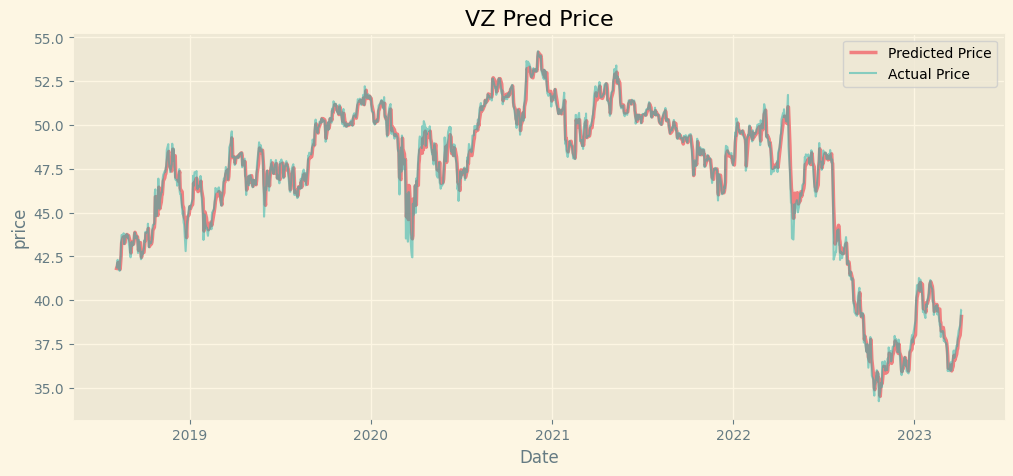

In [ ]:
plt.figure(figsize=(12,5))
plt.title('VZ Pred Price')

sns.set_palette("Set2")
sns.lineplot(data=linear_model_pred_price['price'], linewidth=2.5, label='Predicted Price', color='lightcoral')
sns.lineplot(data=y_test, linewidth=1.5, label='Actual Price', color='lightseagreen', alpha=0.5)